#### Imports

In [1]:
! pip install tensorflow keras --quiet
! pip install seaborn --quiet
! pip install pyyaml h5py --quiet  # Required to save models in HDF5 format

In [2]:
# dataset
import shutil
import os

import pandas as pd
import collections

# model
import numpy as np
import tensorflow as tf
import keras
import time

# graphs/stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

2025-05-22 17:31:26.077271: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 17:31:26.232183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747935086.294001    2072 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747935086.312082    2072 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747935086.440506    2072 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

#### Dataset loading and preprocessing

In [3]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [4]:
# splitting the dataset and getting class names
img_height = 128
img_width = 128
batch_size = 32
SEED = 123 # for reproducibility

# training, test set split
# resizing already handled by TensorFlow
# no need to reshape

print('Loading and splitting the tf_dataset')
train_set, test_set = keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="both",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)
print("Actually the last one is the test set (issue of keras.utils function)")

Loading and splitting the tf_dataset
Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


I0000 00:00:1747935099.564862    2072 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9


Actually the last one is the test set (issue of keras.utils function)


In [5]:
train_set = train_set.map(lambda x, y: (x/255, y))
test_set = test_set.map(lambda x, y: (x/255, y))

test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### Statistics computation

##### Model evaluation

we start by loading both models from the saved files

In [6]:
# load both models
lightCNN = keras.saving.load_model('./saved_model/malaria_det.keras')
baseline = keras.saving.load_model('./saved_model/malaria_mobile_net.keras')

In [7]:
def evaluate_model(model, test_set):
    y_true, y_probs = [], []

    for x_batch, y_batch in test_set:
        preds = model.predict(x_batch, verbose=0).ravel()
        y_probs.extend(preds)
        y_true.extend(y_batch.numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int) # if more than 0.5 classify it as 1

    return y_true, y_probs, y_pred

In [8]:
# Evaluate both models
y_true_1, y_probs_1, y_pred_1 = evaluate_model(lightCNN, test_set)
y_true_2, y_probs_2, y_pred_2 = evaluate_model(baseline, test_set)

# Create output directory
output_dir = "statistics"
os.makedirs(output_dir, exist_ok=True)

I0000 00:00:1747935107.810619    2828 service.cc:152] XLA service 0x7eeadc00ace0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747935107.810992    2828 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-22 17:31:47.873739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747935107.970926    2828 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-05-22 17:31:49.556912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1747935111.332909    2828 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-22 17:32:10.614729: I tensorflow/core/framew

##### Classification reports

In [9]:
# Print reports
print("LightCNN Classification Report")
print(classification_report(y_true_1, y_pred_1, target_names=['Uninfected', 'Parasitized']))
print(f"LightCNN AUC-ROC: {roc_auc_score(y_true_1, y_probs_1):.4f}\n")

print("Baseline Classification Report")
print(classification_report(y_true_2, y_pred_2, target_names=['Uninfected', 'Parasitized']))
print(f"Baseline AUC-ROC: {roc_auc_score(y_true_2, y_probs_2):.4f}\n")

LightCNN Classification Report
              precision    recall  f1-score   support

  Uninfected       0.98      0.94      0.96      2709
 Parasitized       0.94      0.98      0.96      2802

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511

LightCNN AUC-ROC: 0.9907

Baseline Classification Report
              precision    recall  f1-score   support

  Uninfected       0.97      0.96      0.97      2709
 Parasitized       0.96      0.98      0.97      2802

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511

Baseline AUC-ROC: 0.9925



##### ROC curves

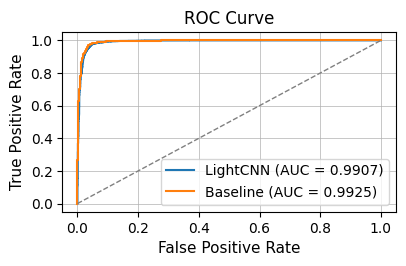

In [10]:
fpr1, tpr1, _ = roc_curve(y_true_1, y_probs_1)
fpr2, tpr2, _ = roc_curve(y_true_2, y_probs_2)

plt.figure(figsize=(4, 2.6))  # Smaller overall figure
plt.plot(fpr1, tpr1, label=f"LightCNN (AUC = {roc_auc_score(y_true_1, y_probs_1):.4f})", linewidth=1.5)
plt.plot(fpr2, tpr2, label=f"Baseline (AUC = {roc_auc_score(y_true_2, y_probs_2):.4f})", linewidth=1.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)

plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)
plt.title("ROC Curve", fontsize=12)
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, linewidth=0.5)

plt.tight_layout(pad=0.5)  # Reduce padding around the plot
roc_path = os.path.join(output_dir, "roc_curve_models.pdf")
plt.savefig(roc_path, bbox_inches='tight')  # Ensure tight bounding box
plt.show()

##### Precision/Recall curves

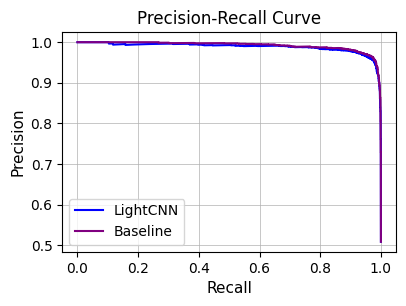

In [11]:
precision1, recall1, _ = precision_recall_curve(y_true_1, y_probs_1)
precision2, recall2, _ = precision_recall_curve(y_true_2, y_probs_2)

plt.figure(figsize=(4, 3))  # Smaller overall figure
plt.plot(recall1, precision1, label="LightCNN", color='blue', linewidth=1.5)
plt.plot(recall2, precision2, label="Baseline", color='purple', linewidth=1.5)

plt.xlabel("Recall", fontsize=11)
plt.ylabel("Precision", fontsize=11)
plt.title("Precision-Recall Curve", fontsize=12)
plt.legend(fontsize=10, loc='lower left')
plt.grid(True, linewidth=0.5)

plt.tight_layout(pad=0.5)  # Reduces padding around the plot
prc_path = os.path.join(output_dir, "precision_recall_curve_models.pdf")
plt.savefig(prc_path, bbox_inches='tight')  # Crops excess whitespace
plt.show()

##### Confusion matrices

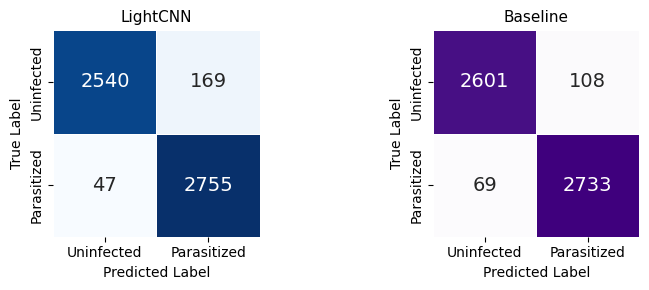

In [12]:
cm1 = confusion_matrix(y_true_1, y_pred_1)
cm2 = confusion_matrix(y_true_2, y_pred_2)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Smaller figure size for LaTeX column

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            square=True, linewidths=0.5,
            annot_kws={"size": 14},
            cbar=False)  # No color bar
axes[0].set_title('LightCNN', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            square=True, linewidths=0.5,
            annot_kws={"size": 14},
            cbar=False)  # No color bar
axes[1].set_title('Baseline', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
confusion_path = os.path.join(output_dir, "confusion_matrices_models.pdf")
plt.savefig(confusion_path, bbox_inches='tight')
plt.show()

##### Inference time and flops

In [13]:
def get_flops_v1(model, input_shape):
    # Convert model to a concrete function
    input_tensor = tf.TensorSpec([1, *input_shape], tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)

    # Get frozen graph
    frozen_func = convert_to_constants(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Profile the graph
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        print(f"FLOPs: {flops.total_float_ops:,}")
        return flops.total_float_ops

def convert_to_constants(concrete_func):
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    return convert_variables_to_constants_v2(concrete_func)

def measure_inference_time(model, input_shape, n_runs=100):
    dummy_input = tf.random.normal((1, *input_shape))
    model(dummy_input)  # Warm-up
    start = time.time()
    for _ in range(n_runs):
        model(dummy_input)
    end = time.time()
    avg_ms = (end - start) / n_runs * 1000
    print(f"Avg inference time: {avg_ms:.2f} ms")
    return avg_ms

# Define the input shape (excluding batch size), e.g., (224, 224, 3)
input_shape = (128, 128, 3)

print("LightCNN:")
flops1 = get_flops_v1(lightCNN, input_shape)
time1 = measure_inference_time(lightCNN, input_shape)

print("\nBaseline:")
flops2 = get_flops_v1(baseline, input_shape)
time2 = measure_inference_time(baseline, input_shape)

LightCNN:
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


I0000 00:00:1747935159.692895    2072 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1747935159.693495    2072 single_machine.cc:374] Starting new session
I0000 00:00:1747935159.704755    2072 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9


FLOPs: 24,785,153

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the imp

I0000 00:00:1747935163.285593    2072 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1747935163.285748    2072 single_machine.cc:374] Starting new session
I0000 00:00:1747935163.293700    2072 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:
FLOPs: 200,645,121

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the im